# Cloud Segmentation with U-Net

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np



from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time

## Preparation & Exploration

In [2]:
if not os.path.exists("pytorch_unet.py"):
    if not os.path.exists("pytorch_unet"):
        !git clone https://github.com/usuyama/pytorch-unet.git

    # %cd pytorch-unet

Cloning into 'pytorch-unet'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 67 (delta 6), reused 1 (delta 0), pack-reused 55
Unpacking objects: 100% (67/67), 338.15 KiB | 1.88 MiB/s, done.


In [3]:
# check torch
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla P100-PCIE-16GB


In [4]:
!ls -l

total 8
---------- 1 root root  263 Jan 10 12:26 __notebook_source__.ipynb
drwxr-xr-x 4 root root 4096 Jan 10 12:28 pytorch-unet


## Init & Prepare

In [5]:
# reference to https://www.kaggle.com/cordmaur/38-cloud-simple-unet

class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y


In [6]:
# create torch dataset like defined in CloudDataset class
base_path = Path('../input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

In [7]:
# returns features x and target feature y
x, y = data[1000]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

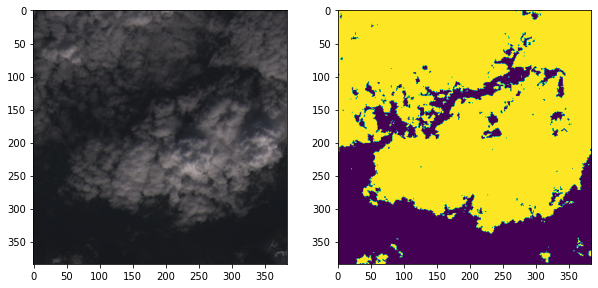

In [8]:
# visualize raw image and ground truth
image_index = 800

fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(image_index))
ax[1].imshow(data.open_mask(image_index))

# left -> raw image
# right Ground-Truth Mask (as binary image)

In [9]:
train_dataset, valid_dataset = torch.utils.data.random_split(data, (6000, 2400))

In [10]:
# Create dataloads sample from dataset

train_dataload = DataLoader(train_dataset, batch_size=3, shuffle=True)
valid_dataload = DataLoader(valid_dataset, batch_size=3, shuffle=True)

In [11]:
# test dataload
xb, yb = next(iter(train_dataload))
xb.shape, yb.shape

(torch.Size([2, 4, 384, 384]), torch.Size([2, 384, 384]))

## Model

In [12]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [13]:
unet = UNET(4,2)

In [14]:
! pip install hiddenlayer

In [15]:
import hiddenlayer as hl

transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(unet, torch.zeros([12, 4, 384, 384]), transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('rnn_hiddenlayer', format='png')

/opt/conda/lib/python3.7/site-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


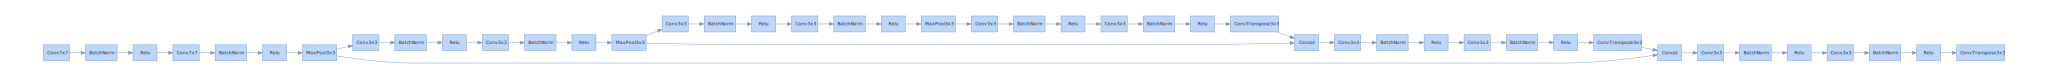

In [16]:
graph

# visualize Unet Layers

In [17]:
# testing one pass
xb, yb = next(iter(train_dataload))
xb.shape, yb.shape

pred = unet(xb)
pred.shape

torch.Size([2, 2, 384, 384])

In [18]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dataload
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dataload

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [ ]:
loss_fn = nn.CrossEntropyLoss() # choose loss function
opt = torch.optim.Adam(unet.parameters(), lr=0.01) # choose gradient function

# start training
train_loss, valid_loss = train(unet, train_dataload, valid_dataload, loss_fn, opt, acc_metric, epochs=2)



Epoch 0/0
----------
train Loss: 0.4723 Acc: 0.7586385011672974
----------
Current step: 100  Loss: 0.4597390592098236  Acc: 0.5481499433517456  AllocMem (Mb): 17.2919921875
Current step: 200  Loss: 0.27386635541915894  Acc: 1.0  AllocMem (Mb): 17.2919921875
Current step: 300  Loss: 0.6454951763153076  Acc: 0.58831787109375  AllocMem (Mb): 17.2919921875
Current step: 400  Loss: 0.2876412868499756  Acc: 0.9394327998161316  AllocMem (Mb): 17.2919921875
Current step: 500  Loss: 0.6273067593574524  Acc: 0.4556715190410614  AllocMem (Mb): 17.2919921875
Current step: 600  Loss: 0.48690181970596313  Acc: 0.602386474609375  AllocMem (Mb): 17.2919921875
Current step: 700  Loss: 0.4572943449020386  Acc: 0.7176547646522522  AllocMem (Mb): 17.2919921875
Current step: 800  Loss: 0.17692606151103973  Acc: 0.9560139775276184  AllocMem (Mb): 17.2919921875


In [ ]:
train_loss

In [ ]:
valid_loss

In [ ]:
# visualize Result
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

## Use the UNET without Training

In [ ]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [ ]:
xb, yb = next(iter(train_dataload))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

In [ ]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))